## Process outline

The process carried out by this workflow can be described as follows:
  - Data from Census PEP 2010-2021 is filtered to only include data from Delaware and Franklin Counties which is combined.
  - Transform tables to aggregate migration information by type and aggregate population growth information by type.
  - Create a stacked bar chart to distingush between international and domestic migration and another to distinguish between natrual population growth and net migration
  

### Import required packages

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

### Parameters

In [87]:
# Adjust the path to where the CSV file is located in your environment
file_path = "censusPep_county_wide.csv"

# Read the CSV file into a DataFrame
data = pd.read_csv(file_path)

### Filter for and sum Delaware and Franklin counties

In [74]:
# Filter for CITYNAME "Delaware" and "Franklin"
filtered_data = data[data['CTYNAME'].isin(['Delaware', 'Franklin'])]
# Group by 'YEAR' and calculate sums for the specified columns
grouped_data = filtered_data.groupby('Year').agg(
    Total_Births=pd.NamedAgg(column='BIRTHS', aggfunc='sum'),
    Total_Deaths=pd.NamedAgg(column='DEATHS', aggfunc='sum'),
    Total_DomesticMig=pd.NamedAgg(column='DOMESTICMIG', aggfunc='sum'),
    Total_InternationalMig=pd.NamedAgg(column='INTERNATIONALMIG', aggfunc='sum'),
    Total_NaturalInc=pd.NamedAgg(column='NATURALINC', aggfunc='sum'),
    Total_NetMig=pd.NamedAgg(column='NETMIG', aggfunc='sum'),
    Total_NPopChg=pd.NamedAgg(column='NPOPCHG', aggfunc='sum'),
    Total_PopEstimate=pd.NamedAgg(column='POPESTIMATE', aggfunc='sum'),
    Total_Residual=pd.NamedAgg(column='RESIDUAL', aggfunc='sum')
).reset_index()

### Aggregation for migration types and population change types

In [75]:
# Melt the DataFrame to "unpivot" the Total_NaturalInc and Total_NetMig columns
growth_data = pd.melt(grouped_data, id_vars=['Year'], value_vars=['Total_NaturalInc', 'Total_NetMig'], var_name='ChangeType', value_name='PopChange')

# Replace 'Total_NaturalInc' and 'Total_NetMig' with 'NatGrowth' and 'Migration' respectively in the 'ChangeType' column
growth_data['ChangeType'] = growth_data['ChangeType'].map({'Total_NaturalInc': 'NatGrowth', 'Total_NetMig': 'Migration'})

# Sort by 'Year'
growth_data_sorted = growth_data.sort_values(by='Year')

# Melt the DataFrame to "unpivot" the Total_DomesticMig and Total_InternationalMig columns
migration_data = pd.melt(grouped_data, id_vars=['Year'], value_vars=['Total_DomesticMig', 'Total_InternationalMig'], var_name='ChangeType', value_name='PopChange')

# Replace 'Total_DomesticMig' and 'Total_InternationalMig' with 'DomesticMig' and 'InternationalMig' respectively in the 'ChangeType' column
migration_data['ChangeType'] = migration_data['ChangeType'].map({'Total_DomesticMig': 'DomesticMig', 'Total_InternationalMig': 'InternationalMig'})

# Sort by 'Year'
migration_data_sorted = migration_data.sort_values(by='Year')

### Creating stacked bar charts

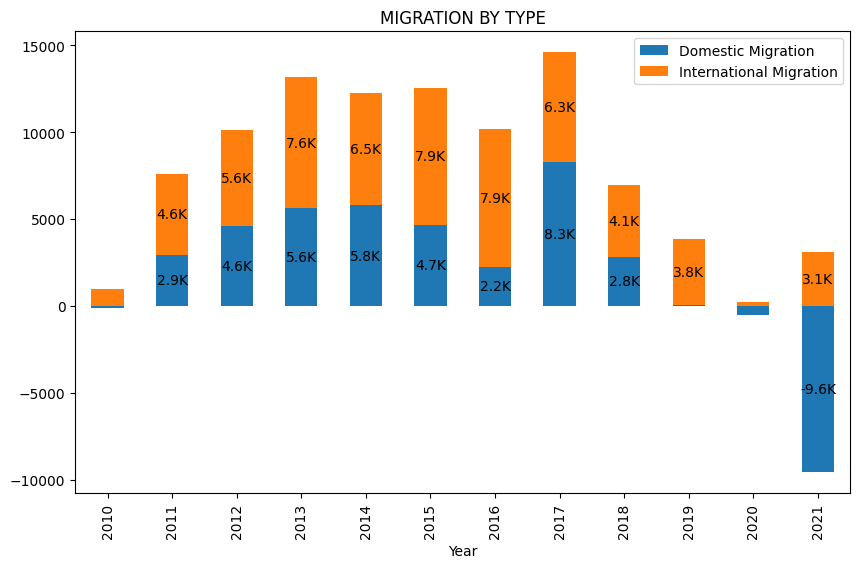

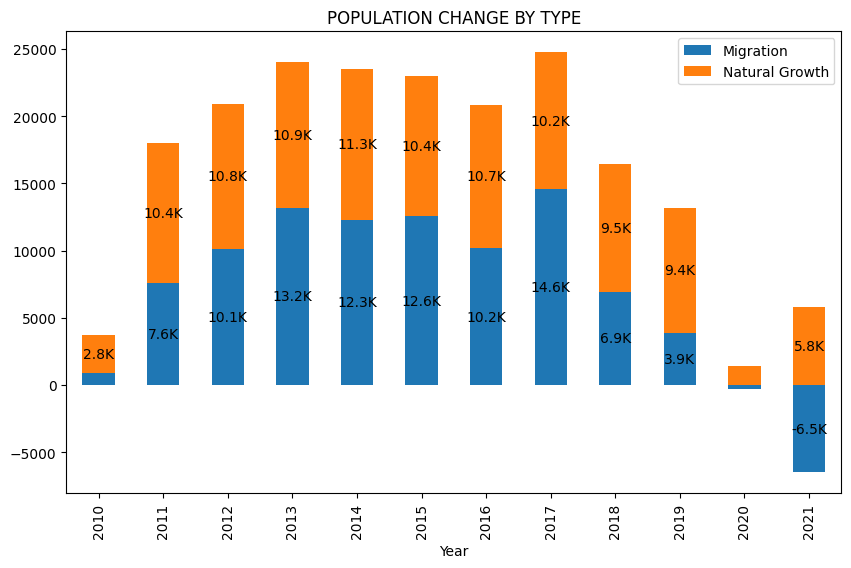

In [83]:
# Pivot the DataFrame to have 'Year' as the index, 'ChangeType' as the columns, and 'PopChange' as the values
pivoted_migration_data = migration_data_sorted.pivot(index='Year', columns='ChangeType', values='PopChange').fillna(0)

# Rename the columns for the legend
pivoted_migration_data.columns = ['Domestic Migration', 'International Migration']

# Plot the stacked bar chart
ax=pivoted_migration_data.plot(kind='bar', stacked=True, figsize=(10, 6))

# Adding labels to each bar, omitting labels for values less than 1.5K
for container in ax.containers:
    labels = [f'{x/1000:.1f}K' if abs(x) >= 1500 else '' for x in container.datavalues]
    ax.bar_label(container, labels=labels, label_type='center')
plt.title('MIGRATION BY TYPE')

# Show the plot
plt.show()

# Pivot the DataFrame to have 'Year' as the index, 'ChangeType' as the columns, and 'PopChange' as the values
pivoted_growth_data = growth_data_sorted.pivot(index='Year', columns='ChangeType', values='PopChange').fillna(0)

# Rename the columns for the legend
pivoted_growth_data.columns = ['Migration', 'Natural Growth']

# Plot the stacked bar chart
ax= pivoted_growth_data.plot(kind='bar', stacked=True, figsize=(10, 6))

# Adding labels to each bar, omitting labels for values less than 1.5K
for container in ax.containers:
    labels = [f'{x/1000:.1f}K' if abs(x) >= 1500 else '' for x in container.datavalues]
    ax.bar_label(container, labels=labels, label_type='center')

plt.title('POPULATION CHANGE BY TYPE')

# Show the plot
plt.show()